## 配置环境

In [1]:
import os # Configure which GPU 
gpu_num = 0 # Use "" to use the CPU
os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Colab does currently not support the latest version of ipython.
# Thus, the preview does not work in Colab. However, whenever possible we 
# strongly recommend to use the scene preview mode.
try: # detect if the notebook runs in Colab
    import google.colab
    colab_compat = True # deactivate preview
except:
    colab_compat = False
resolution = [480,320] # increase for higher quality of renderings

# Allows to exit cell execution in Jupyter
class ExitCell(Exception):
    def _render_traceback_(self):
        pass

# Import Sionna
try:
    import sionna
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    os.system("pip install sionna")
    import sionna

# Configure the notebook to use only a single GPU and allocate only as much memory as needed
# For more details, see https://www.tensorflow.org/guide/gpu
import tensorflow as tf
import tensorflow_addons as tfa
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e) 
# Avoid warnings from TensorFlow
tf.get_logger().setLevel('ERROR')

tf.random.set_seed(1) # Set global random seed for reproducibility
            
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import sys
import sionna.rt as rt
from sionna.constants import PI
from sionna.channel import cir_to_ofdm_channel
import pickle
from utils import Continuous_scatter

/home/zhl/miniconda3/envs/sionna/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


## 计算路径

In [5]:
alpha_r = [2,2,2,2,2] # 2 for Gaussion approximate is equal to 5 for Backscattering
alpha_i = 10
lambda_ = 0.75
scene_path = "sim_city"
scene = rt.load_scene("./scene/" + scene_path + "/" + scene_path + ".xml")
scene.scattering_pattern_callable = Continuous_scatter(alpha_r=alpha_r, alpha_i=alpha_i, lambda_= lambda_)
i = 0
for _, obj in scene.objects.items():
    obj.radio_material.relative_permittivity = 1
    obj.radio_material.conductivity = 1e7
    obj.radio_material.scattering_coefficient =1
    #obj.radio_material.scattering_pattern_callable = Continuous_scatter(alpha_r=alpha_r[i], alpha_i=alpha_i, lambda_= lambda_)
    i = i + 1

scene.tx_array = rt.PlanarArray(num_rows=1, num_cols=1, vertical_spacing=0.5, horizontal_spacing=0.5, pattern="iso", 
                                polarization="V")
scene.rx_array = scene.tx_array
"""
d_Tx = 10
d_Rx = 10
bias = -1.2
theta_Tx = PI * (1 - 3/12)
theta_Rx = PI * 3/12

 # config for reflector
Tx_pos = [0, d_Tx * np.cos(theta_Tx)+bias, d_Tx * np.sin(theta_Tx)]
Rx_pos = [0, d_Rx * np.cos(theta_Rx)+bias, d_Rx * np.sin(theta_Rx)]

# config for double_reflector
Tx_pos = [0, d_Tx * np.cos(theta_Tx)+bias, d_Tx * np.sin(theta_Tx) + 4]
Rx_pos = [0, d_Rx * np.cos(theta_Rx)+bias, d_Rx * np.sin(theta_Rx) + 4]
"""

# config for sim_city
Tx_height = 5
Rx_pos_x = 10
Rx_pos_y = -10
Tx_pos = [0, 0, Tx_height]
Rx_pos = [Rx_pos_x, Rx_pos_y, 10]
scene.add(rt.Transmitter(name="Tx", position=Tx_pos))
scene.add(rt.Receiver(name="Rx", position=Rx_pos))
paths = scene.compute_paths(check_scene=False, num_samples=1e6, los=False, reflection=False, scattering=True, scat_keep_prob=1)
amp = tf.reshape(paths.a, [-1])
tau = tf.reshape(paths.tau, [-1])
theta_r = tf.reshape(paths.theta_r, [-1])
phi_r = tf.reshape(paths.phi_r, [-1])
#scene.preview(paths=paths)

## 计算能量图

In [5]:
""" GPU_memory = 8e9
dtype = tf.float32
if len(amp) > 1e5:
    granularity = int((GPU_memory/len(amp)/dtype.size)**0.5/4)*4
else:
    granularity = 151 """
granularity = 108
print(f"resolution:{granularity}*{granularity}")
theta_start = np.min(theta_r) - 0.1
theta_end = np.max(theta_r) + 0.1
phi_start = np.max(phi_r) + 0.1
phi_end = np.min(phi_r) - 0.1
bandwidth = 50e6
carrier_freq = 3.5e9
N = 100
frequencies = tf.linspace(carrier_freq-bandwidth/2, carrier_freq-bandwidth/2, N)
#a = tf.math.divide(a, tf.math.reduce_sum(a)) #normalize total energy
y = (theta_r - theta_start) / (theta_end - theta_start) * granularity
y = tf.cast(y, dtype=tf.int32)
x = (phi_r - phi_start) / (phi_end - phi_start) * granularity
x = tf.cast(x, dtype=tf.int32)
temp = tf.ones([granularity, len(amp)], dtype=tf.int32)
eye = tf.linalg.diag(tf.linspace(0,granularity-1,granularity))
temp = tf.matmul(tf.cast(eye, dtype=tf.int32), temp)
i_aug = (x == temp)
j_aug = (y == temp)
i_aug = tf.split(i_aug, num_or_size_splits=granularity, axis=0)
ind = tf.logical_and(j_aug, i_aug) #size:granularity^2*len(a)*datasize
# To consider the effect of bandwidth, run part1; or run part2
# part1
ind = tf.reshape(ind, [granularity**2, len(amp)])
def cal_energy_in_band(ind):
    indices = tf.where(ind)
    tmp_a = tf.gather(amp, indices)
    tmp_a = tf.reshape(tmp_a, [1,1,1,1,1,len(tmp_a),1])
    tmp_tau = tf.gather(tau, indices)
    tmp_tau = tf.reshape(tmp_tau, [1,1,1,1,1,len(tmp_tau)])
    h_f = cir_to_ofdm_channel(frequencies=frequencies, a=tmp_a, tau=tmp_tau)
    h_f = tf.reshape(h_f, [-1])
    return tf.reduce_sum(tf.math.pow(tf.math.abs(h_f), 2)) / N
@tf.function
def func(elems):
    return tf.map_fn(cal_energy_in_band, elems, dtype=tf.float32)
heat_tab = func(ind)
heat_tab = tf.reshape(heat_tab, [granularity, granularity]).numpy()

# part2
""" a = tf.abs(amp)
a = tf.math.pow(a, 2)
ind = tf.cast(ind, dtype=tf.float32)
heat_tab = tf.tensordot(ind, a, axes=1).numpy() """


resolution:108*108


' a = tf.abs(amp)\na = tf.math.pow(a, 2)\nind = tf.cast(ind, dtype=tf.float32)\nheat_tab = tf.tensordot(ind, a, axes=1).numpy() '

In [8]:
## 存图
with open('./data/heat_tab_2.pkl', 'wb') as file:
    pickle.dump(heat_tab, file)

In [2]:
## 读图
with open('./data/heat_tab_1.pkl', 'rb') as file:
    heat_tab1 = pickle.load(file)  # [5,5,20,5,5]
with open('./data/heat_tab_2.pkl', 'rb') as file:
    heat_tab2 = pickle.load(file)  # [5,5,20,5,5]
with open('./data/heat_tab3.pkl', 'rb') as file:
    heat_tab3 = pickle.load(file)  # [20,20,20,20,20]
#heat_tab = heat_tab3
with open('./data/heat_tab_low_res.pkl', 'rb') as file:
    heat_tab_low_res = pickle.load(file)
#heat_tab = heat_tab_low_res

In [ ]:
mae = tf.reduce_mean(tf.abs(heat_tab_low_res - heat_tab))
print(mae)

In [3]:
heat_tab1 = tfa.image.gaussian_filter2d(image=heat_tab1, filter_shape=(5,5), sigma=10.0, padding="CONSTANT", constant_values=0)
heat_tab1 /= np.sum(heat_tab1)
#heat_tab2 = tfa.image.gaussian_filter2d(image=heat_tab2, filter_shape=(5,5), sigma=10.0, padding="CONSTANT", constant_values=0)
heat_tab2 /= np.sum(heat_tab2)
heat_tab3 = tfa.image.gaussian_filter2d(image=heat_tab3, filter_shape=(5,5), sigma=10.0, padding="CONSTANT", constant_values=0)
heat_tab3 /= np.sum(heat_tab3)
# 对观测结果高斯滤波+归一化，对仿真结果归一化，能将匹配点的MSE相对错误点的MSE降低1/2, MAE降低1/5
heat_tab_low_res = tfa.image.gaussian_filter2d(image=heat_tab_low_res, filter_shape=(3,3), sigma=2.5, padding="CONSTANT", constant_values=0)

## 画图

Text(-0.2, 1, 'Model=BS,alpha_r=[2, 2, 2, 2, 2],alpha_i=10,lambda=0.75,(10,0)')

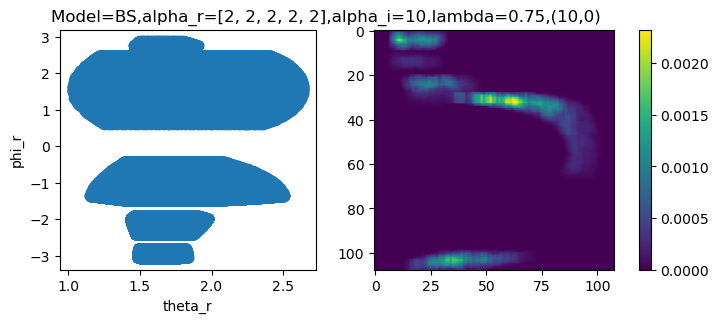

In [7]:
# downsampling for search algorithm
""" heat_tab = tf.tensordot(ind, a, axes=1)
heat_tab = tf.expand_dims(heat_tab, axis=0)
heat_tab = tf.expand_dims(heat_tab, axis=3)
heat_tab_1 = 4 * tf.nn.avg_pool2d(heat_tab, [1,2,2,1], [1,2,2,1], padding="VALID")
heat_tab_2 = 4 * tf.nn.avg_pool2d(heat_tab_1, [1,2,2,1], [1,2,2,1], padding="VALID")
heat_tab = tf.squeeze(heat_tab).numpy()
heat_tab_1 = tf.squeeze(heat_tab_1).numpy()
heat_tab_2 = tf.squeeze(heat_tab_2).numpy() """ 
# cal variance
""" heat_tab_not_zero = heat_tab.ravel()[np.flatnonzero(heat_tab)]
variance = np.var(heat_tab_not_zero)
variance = np.nan """
plt.figure()
#plt.subplot(1,2,1)
plt.axes([0.35, 0.35, 0.4, 0.5])
plt.scatter(theta_r, phi_r)
plt.xlabel(f'theta_r')#,theta_Rx={theta_Rx/PI*180:.3g},theta_Tx={theta_Tx/PI*180:.3g},sigma={variance:.3g}')
plt.ylabel('phi_r')
#plt.subplot(1,2,2)
plt.axes([0.6, 0.35, 0.77, 0.5])
im = plt.imshow(heat_tab1)
plt.colorbar(im)
plt.title(f"Model=BS,alpha_r={alpha_r},alpha_i={alpha_i},lambda={lambda_},({Rx_pos_x},{Rx_pos_y})", x=-0.2, y=1)

In [ ]:
# 能量边缘分布图
plt.figure()
plt.subplot(1,2,1)
plt.plot(np.sum(heat_tab, axis=0))
plt.subplot(1,2,2)
plt.plot(np.sum(heat_tab, axis=1))

In [6]:
# 场景示意图
scene.preview()

Renderer(camera=PerspectiveCamera(aspect=1.31, children=(DirectionalLight(intensity=0.25, position=(0.0, 0.0, …

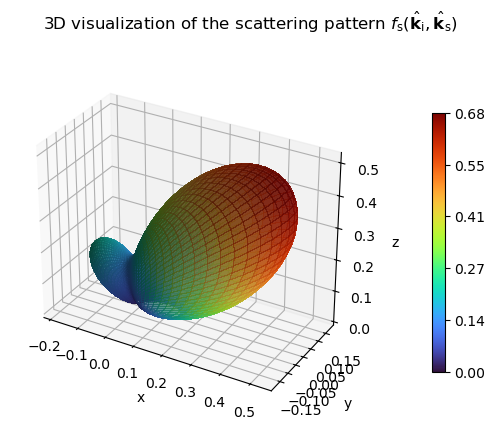

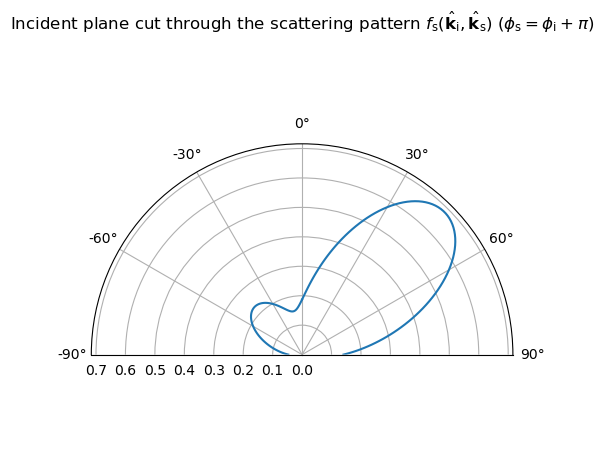

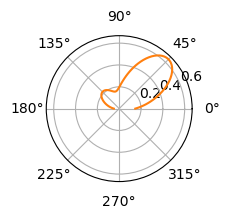

In [11]:
# 材料散射特性图
rt.BackscatteringPattern(alpha_r=10, alpha_i=10, lambda_= 0.75).visualize()
Continuous_scatter(alpha_r=[5], alpha_i=5, lambda_=0.75, i_mask=False).visualize()

以下是聚类算法，暂时不用。

In [ ]:
heat_tab += (heat_tab!=0)+1e-30
type_tab = np.zeros(heat_tab.shape)
rand_num = 5
cluster_centers = type_tab.shape[0] * np.random.rand(rand_num,2)
old_cluster_centers = cluster_centers.copy()
epsilon = 1e2
print(cluster_centers)

In [ ]:
for i in range(type_tab.shape[0]):
    for j in range(type_tab.shape[1]):
        temp = cluster_centers - np.array([i,j])
        temp = np.power(temp, 2)
        temp = np.sum(temp, axis=1)
        type_tab[i,j] = np.argmin(temp)
plt.figure()
plt.subplot(1,2,2)
plt.scatter(cluster_centers[:,1],cluster_centers[:,0])
im = plt.imshow(type_tab)
plt.colorbar(im)
plt.subplot(1,2,1)
plt.imshow(heat_tab)

In [ ]:

for i in range(rand_num):
    sum = 0
    temp_center = 0
    ind = np.where(type_tab==i)
    ind = np.vstack((ind[0],ind[1]))
    if ind.size > 2:
        for j in range(ind.shape[1]):
            sum += heat_tab[ind[0,j],ind[1,j]]
            temp_center += heat_tab[ind[0,j],ind[1,j]]*ind[:,j]
        temp_center /= sum
        cluster_centers[i] = temp_center
""" print(np.sum(np.power(cluster_centers - old_cluster_centers, 2)))
if np.sum(np.power(cluster_centers - old_cluster_centers, 2)) < epsilon:
    break
old_cluster_centers = cluster_centers.copy() """
    

plt.figure()
plt.subplot(1,2,2)
plt.scatter(cluster_centers[:,1],cluster_centers[:,0])
im = plt.imshow(type_tab)
plt.colorbar(im)
plt.subplot(1,2,1)
plt.imshow(heat_tab)
#print(cluster_centers)